# HandWritten Digit Recognition

In [1]:
import os
import struct 
import numpy as np
import matplotlib.pyplot as plt

## Function For Load MNIST Data

The load_mnist function returns two arrays, the first being an n*m dimensional NumPy array (images),where n is the number of examples and m is the number of features (here, pixels). 
The training dataset consists of 60,000 training digits and the test dataset contains 10,000 examples, respectively.

The images in the MNIST dataset consist of pixels, and each pixel is represented by a grayscale intensity value. Here, we unroll the pixels into one-dimensional row vectors, which represent the rows in our images array (784 per row or image). The second array (labels) returned by the load_mnist function contains the corresponding target variable, the class labels (integers 0-9) of the handwritten digits.


In [ ]:
def load_mnist(path,kind='train'):
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte' % kind) #path for image labels
    images_path = os.path.join(path,'%s-images-idx3-ubyte' % kind) #path for image
    with open(labels_path,'rb') as lbpath:
        magic,n = struct.unpack('>II',lbpath.read(8)) # '>':refers to Big-Endian it define the order to in which sequence of bytes are stored and 'I':refers to Unsigned Integer
        labels = np.fromfile(lbpath,dtype=np.uint8)
        
    with open(images_path,'rb') as imgpath:
        magic,num,row,cols = struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels),784)
        images = ((images/255.)-.5)*2 # normalize the pixel value in range -1 to 1 due to this gradient based optimization is much more stable
    
    return images,labels

## Loading Train and Test Instances 

In [ ]:
X_train ,y_train = load_mnist('path',kind='train')
X_test,y_test = load_mnist('path',kind='test')
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0],X_test.shape[1])

## Save the Data Into new file after Preprocessing it which is done in function load_mnist() 

In [ ]:
np.savez_compressed('mnist_scaled.npz',X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)

## after Created .npz file now we loaded

In [2]:
mnist = np.load('mnist_scaled.npz')
X_train,y_train,X_test,y_test = [mnist[f] for f in mnist.files]

# Implementing MLP
    
 ## Parameters:
    n_hidden: number of hidden layers.
    l2:l2 regularization to prevent overfitting.
    epochs:number of itterative loops over training example.
    eta:learning rate.
    shuffle: shuffle traing data after every epoch to prevent the same pattern of input then previous.
    minibatch_size: for implementing Stocastic gradient descent to find global minima of cost function.
    seed: random seed for Initializing weights and shuffling.

In [3]:
class NeuralNetMLP(object):
    def __init__(self,n_hidden=100,l2=0.0,epochs=100,eta=0.001,shuffle=True,minibatch_size=1,seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    
    def OneHot_encode(self,Y,n_classes):#encoded label into one hot representation
        onehot = np.zeros((n_classes,Y.shape[0]))  #numpy array of zeros of shape 10 x number of examples [10={0-9}] label value are 0-9
        for idx,val in enumerate(Y.astype(int)):   #Y.astype(int) for makesure target value is int type
            onehot[val,idx]=1                      # replace 0.0 with 1, val is related to label and idx is indices of nth example
        return onehot.T
    
    def sigmoid_fun(self,z): # to put the range of net input in range between 0-1 for the activation value of next layer
        return (1/(1+np.exp(-np.clip(z,-250,250)))) #np.clip(z,-250,250) because mnist dataset has pixel value -250-255  -250 means background (white), 255 means foreground (black).
    
    def forward_propagation(self,X):
        z_h = np.dot(X,self.w_h)+self.b_h  # net input first layer w_h: weight b/w input and hidden layer, b_h: biased value
        a_h = self.sigmoid_fun(z_h) # activation of hidden layer
        z_out = np.dot(a_h,self.w_out)+self.b_out # net input of output layer w_out:wight b/w hidden and output layer and b_out biased value
        a_out = self.sigmoid_fun(z_out) # activation of output layer
        return z_h,a_h,z_out,a_out
    
    def Cost_fun(self,Y_enc,output):#logistic cost function
        l2_term = (self.l2*(np.sum(self.w_h**2)+np.sum(self.w_out**2)))
        term1 = -Y_enc*(np.log(output))
        term2 = (1-Y_enc)*np.log(1-output)
        cost = np.sum(term1-term2)+l2_term
        return np.sum(cost)
    
    def predict(self,X):
        z_h,a_h,z_out,a_out = self.forward_propagation(X)
        Y_pred = np.argmax(z_out,axis=1) # return the index of max element
        return Y_pred
    
    def fit(self,X_train,y_train,X_valid,y_valid):
        n_output = np.unique(y_train).shape[0] # unique values of y_train which is between 0-9 
        n_features = X_train.shape[1]  # 784 features 
        self.b_h = np.zeros(self.n_hidden) # biased value b/w n_features and n_hidden layers
        self.w_h = self.random.normal(loc=0.0,scale=0.1,size=(n_features,self.n_hidden)) # weight b/w n_features and n_hidden layers number of weight n_features*n_hidden
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0,scale=0.1,size=(self.n_hidden,n_output)) # weight b/w n_hidden and n_output layer number of weight n_hidden*n_output
        self.eval = {'cost':[],'train_acc':[],'valid_acc':[]}
        y_train_enc = self.OneHot_encode(y_train,n_output)
        
        for i in range(self.epochs):
            indices = np.arange(X_train.shape[0])# indices for 60000 training samples
            if(self.shuffle):
                self.random.shuffle(indices)
            
            for start_idx in range(0,indices.shape[0]-self.minibatch_size+1,self.minibatch_size):#compute starting index of minibatches
                batch_idx = indices[start_idx:start_idx+self.minibatch_size] # minibatches start and ending index
                z_h,a_h,z_out,a_out = self.forward_propagation(X_train[batch_idx])
                
                ## Back Propagation
                delta_out = a_out-y_train_enc[batch_idx]
                sigmoid_derivative = a_h*(1-a_h)
                delta_h = np.dot(delta_out,self.w_out.T)*sigmoid_derivative
                grad_w_h = np.dot(X_train[batch_idx].T,delta_h)
                grad_b_h = np.sum(delta_h,axis=0)
                
                grad_w_out = np.dot(a_h.T,delta_out)
                grad_b_out = np.sum(delta_out,axis=0)
                
                #Regularization and Weight Updates
                
                delta_w_h = (grad_w_h+self.l2*self.w_h) #regularization
                delta_b_h = grad_b_h #biased unit in not regularized
                delta_w_out = (grad_w_out+self.l2*self.w_out) #regularization
                delta_b_out = grad_b_out #biased unit in not regularized
                
                self.w_h-= self.eta*delta_w_h
                self.b_h-= self.eta*delta_b_h
                self.w_out-= self.eta*delta_w_out
                self.b_out-= self.eta*delta_b_out
            
                #Evaluation after each epoch
                
            z_h,a_h,z_out,a_out = self.forward_propagation(X_train)
            cost = self.Cost_fun(y_train_enc,a_out)

            y_train_pred = self.predict(X_train) #predict data from training sample
            y_valid_pred = self.predict(X_valid) #predict data from new sample

            train_acc = ((np.sum(y_train==y_train_pred)).astype(float)/X_train.shape[0]) # number sample predict correct divide by total number of sample
            valid_acc = ((np.sum(y_valid==y_valid_pred)).astype(float)/X_valid.shape[0]) # number sample predict correct divide by total number of sample

            self.eval['cost'].append(cost)
            self.eval['train_acc'].append(train_acc)
            self.eval['valid_acc'].append(valid_acc)
        return self

                
                                

## Neural Network

In [44]:
nn = NeuralNetMLP(n_hidden=100,l2=0.1,epochs=200,eta=0.0005,shuffle=True,minibatch_size=100,seed=1)
nn.fit(X_train=X_train[:55000],y_train=y_train[:55000],X_valid=X_train[55000:],y_valid=y_train[55000:])

## Graph of cost vs number of epochs

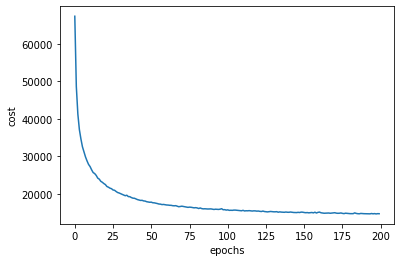

In [45]:
plt.plot(range(nn.epochs),nn.eval['cost'])
plt.ylabel("cost")
plt.xlabel("epochs")
plt.show()

## Graph of Training accuracy and Validation test accuracy vs number of epochs
    To Check Weather model is Overfitting Or not.
    if the curve of valid_acc is away from curve of train_acc it means model is overfitting 
    to tackle this situation we increase the value l2 regularization. 

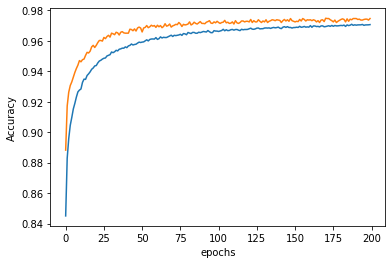

In [46]:
plt.plot(range(nn.epochs),nn.eval['train_acc'])
plt.plot(range(nn.epochs),nn.eval['valid_acc'])
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.show()

## Prediction

In [52]:
predict = nn.predict(X_test)
acc = (np.sum(predict==y_test).astype(float)/X_test.shape[0])
print("accuracy is :",acc*100,"%")

accuracy is : 96.63000000000001 %
